# Erroneous Clustering Detection in High Dimensional Data

In [1]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random

from gap_statistic import OptimalK

import warnings
warnings.filterwarnings('ignore')
optimalK = OptimalK(parallel_backend='joblib')

def generate_uniform_dist(nr_points, nr_features, min_val = -3, max_val = 3, seed = 0):
    np.random.seed(seed)
    return np.random.uniform(min_val, max_val, size=(nr_points, nr_features))

def generate_gaussian_dist(nr_points, nr_features, seed = 0):
    means = np.zeros(nr_features)
    cov = np.eye(nr_features)
    np.random.seed(seed)
    return np.random.multivariate_normal(means, cov, size=nr_points)

## The Datasets

### Gaussian

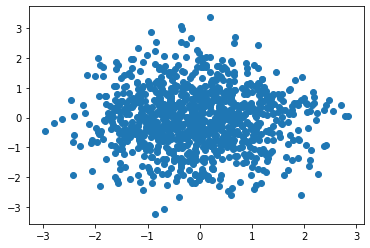

In [2]:
gaussian_data = generate_gaussian_dist(1000,100)
plt.scatter(gaussian_data[:,0], gaussian_data[:,1])
plt.show()

### Uniform

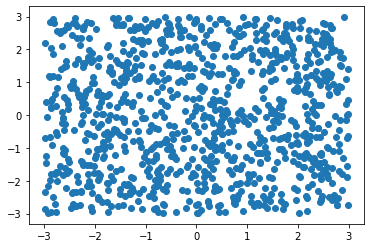

In [3]:
uniform_data = generate_uniform_dist(1000,100)
plt.scatter(uniform_data[:,0], uniform_data[:,1])
plt.show()

## Evaluation of Global Methods

### Multidimensional Scaling

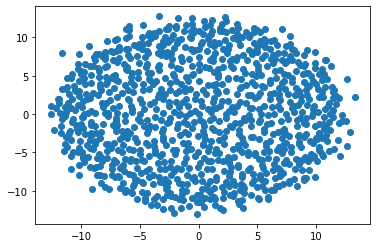

In [4]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(gaussian_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

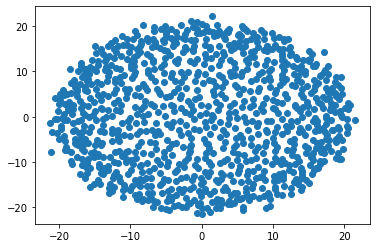

In [5]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(uniform_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

### Principal Component Analysis

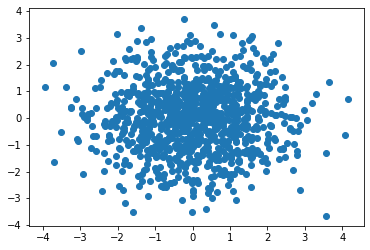

In [6]:
pca = PCA(n_components=2)
X = pca.fit_transform(gaussian_data)  
plt.scatter(X[:,0], X[:,1])
plt.show()

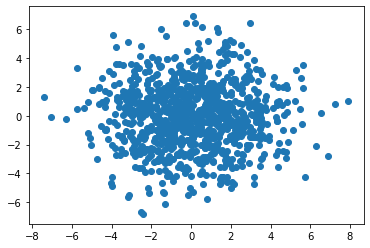

In [7]:
pca = PCA(n_components=2)
X = pca.fit_transform(uniform_data)  
plt.scatter(X[:,0], X[:,1])
plt.show()

## Evaluation of Local Methods

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

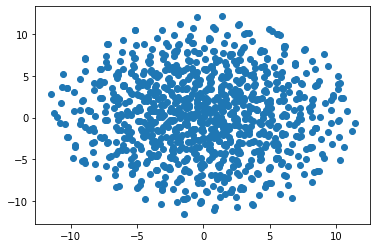

In [8]:
X_embedded = TSNE(n_components=2).fit_transform(gaussian_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

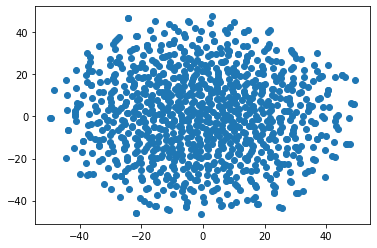

In [9]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(uniform_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

### Isomap

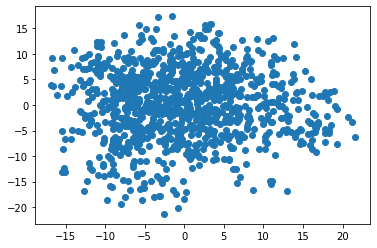

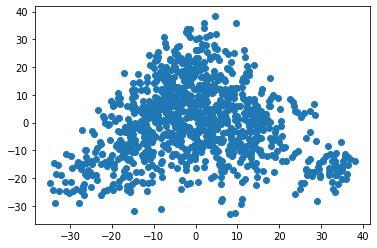

In [10]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(gaussian_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

X_transformed = embedding.fit_transform(uniform_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

## Varying the datasets

### Lower dimensions, 4 <= K <= 10

In [11]:
gaussian_data = generate_gaussian_dist(nr_points=500,nr_features=4)
uniform_data = generate_uniform_dist(nr_points=500,nr_features=4)

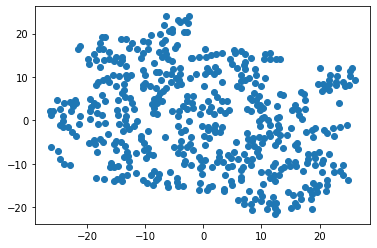

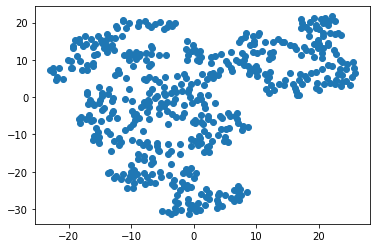

In [12]:
X_embedded = TSNE(n_components=2).fit_transform(gaussian_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

X_embedded = TSNE(n_components=2).fit_transform(uniform_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

#### MDS

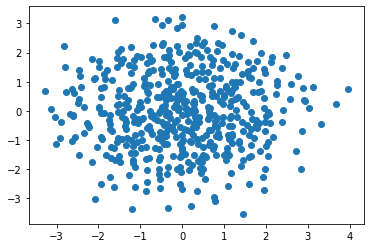

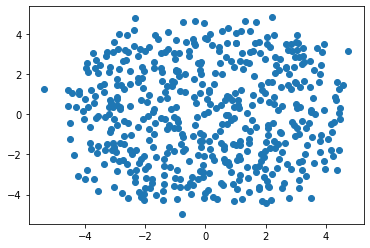

In [13]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(gaussian_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(uniform_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

#### PCA

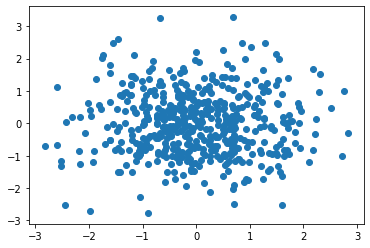

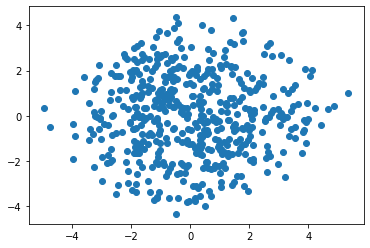

In [14]:
pca = PCA(n_components=2)
X = pca.fit_transform(gaussian_data)  
plt.scatter(X[:,0], X[:,1])
plt.show()

pca = PCA(n_components=2)
X = pca.fit_transform(uniform_data)  
plt.scatter(X[:,0], X[:,1])
plt.show()

#### Isomap

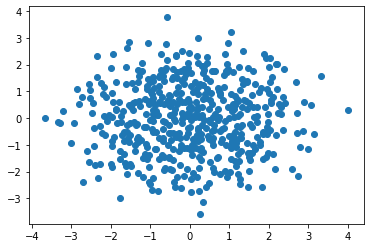

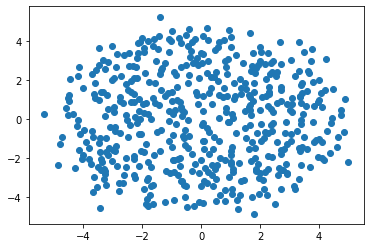

In [15]:
X_transformed = embedding.fit_transform(gaussian_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

X_transformed = embedding.fit_transform(uniform_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

## Reduction to three dimensions

In [16]:
gaussian_data = generate_gaussian_dist(nr_points=200,nr_features=1000)
uniform_data = generate_uniform_dist(nr_points=200,nr_features=1000)

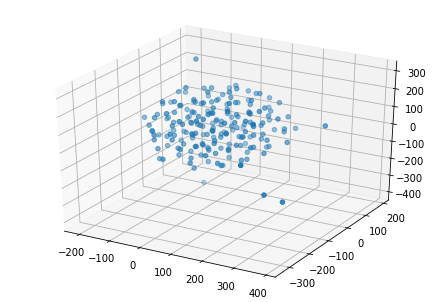

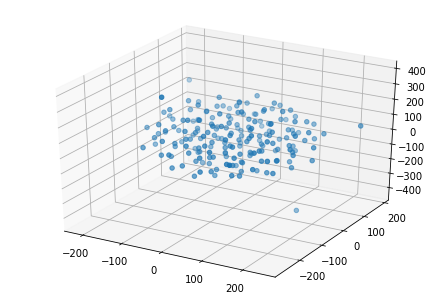

In [17]:
fig = plt.figure()
ax = Axes3D(fig)

X_embedded = TSNE(n_components=3).fit_transform(gaussian_data)
ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2])
plt.show()

fig = plt.figure()
ax = Axes3D(fig)

X_embedded = TSNE(n_components=3).fit_transform(uniform_data)
ax.scatter(X_embedded[:,0], X_embedded[:,1],X_embedded[:,2])
plt.show()

## Higher dimensions

In [18]:
gaussian_data = generate_gaussian_dist(nr_points=200,nr_features=10)
uniform_data = generate_uniform_dist(nr_points=200,nr_features=10)

### TSNE

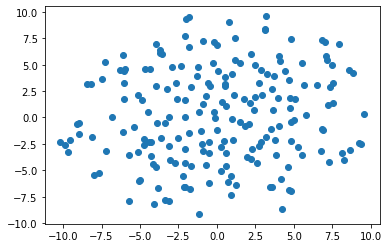

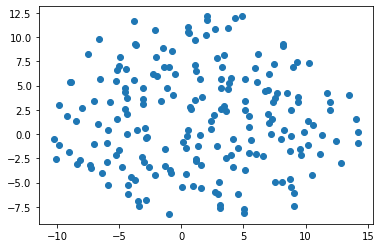

In [19]:
X_embedded = TSNE(n_components=2).fit_transform(gaussian_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

X_embedded = TSNE(n_components=2).fit_transform(uniform_data)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

### Isomap

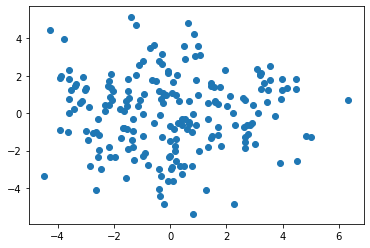

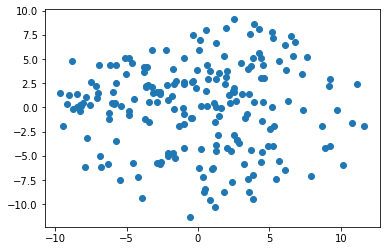

In [22]:
gaussian_data = generate_gaussian_dist(nr_points=200,nr_features=10)
uniform_data = generate_uniform_dist(nr_points=200,nr_features=10)

embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(gaussian_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

X_transformed = embedding.fit_transform(uniform_data)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()